### LightGBM with Focal Loss for Multiclass classification problems

Let me show how to adapt the Focal Loss implementation for binary classification to a multiclass classification problem.

The idea is to face the problem using the Binary Cross Entropy With Logits (borrowing from `Pytorch` notation `BCEWithLogitsLoss`). 

$$
loss = -[y_{\text true} \cdot log\sigma(x) + (1-y_{\text true}) \cdot log(1-\sigma(x))] 
$$

Where $\sigma$ is the sigmoid function

For example, let's assume we have a problem with 10 classes and we have two samples/observations

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(handle_unknown='ignore')
cont = pd.read_csv("../y(ternary).csv", index_col=0, parse_dates=True)
y_true = cont["bin"].values
# from -2 to 2 to illustrate the fact the preds coming from lightGBM when using custom losses are NOT probs
y_pred = np.random.uniform(low=-2, high=2, size=(59857, 3))

In [2]:
# labels
y_true

array([1., 1., 1., ..., 0., 0., 0.])

In [3]:
# predictions
y_pred

array([[ 1.61729009,  1.59184397, -0.70070491],
       [-0.18752028,  0.25128241,  1.93850385],
       [-0.03107515,  0.43374542, -1.71906226],
       ...,
       [-1.36776786, -1.85231527, -1.02481557],
       [-0.83827334, -1.59630457,  0.94102909],
       [-0.85277219,  1.75902977,  1.0285099 ]])

In [4]:
def sigmoid(x): 
    return 1./(1. +  np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)

In [5]:
# labels one-hot encoded
y_true_oh = enc.fit_transform(y_true.reshape((-1, 1))).toarray()

In [6]:
y_true_oh

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [7]:
# BCEWithLogitsLoss
( -( y_true_oh * np.log(sigmoid(y_pred)) + (1-y_true_oh) * np.log(1-sigmoid(y_pred)) ) ).mean()

0.846067954007902

### Multiclass Focal Loss

Before we jump to the Focal Loss code, let's focus for one second in a sentence in the LightGBM [documentation](https://lightgbm.readthedocs.io/en/latest/index.html) site : *"For multi-class task, the preds is group by class_id first, then group by row_id. If you want to get i-th row preds in j-th class, the access way is score[j $\times$ num_data + i] and you should group grad and hess in this way as well."*

Let's assume we have 100 rows and 4 classes

In [8]:
preds = np.random.rand(100*4)

To access to the prediction for class `1` for the 20-th row we need the index 1 $\times$ 100 + 20 = 120

We will compute the Focal Loss using the `BCEWithLogitsLoss` which requires that we have an array of predictions of shape (num_data, num_class). 

Therefore, to reshape the predictions (scores) coming from lightGBM to that format, we need to use 'Fortran' style.

In [9]:
preds[120]

0.6502855554830614

In [10]:
preds.reshape(-1 , 4, order='F')[20, 1]

0.6502855554830614

And in general

In [11]:
np.all(preds[:100] == preds.reshape(-1 , 4, order='F')[:100,0])

True

So, without further ado:

In [12]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')

And that's it really. Now one would want/need the corresponding evalulation function.

In [13]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

In [161]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.special import softmax

scores = []
y_pred = []

def cross_validate(X, y, cvGen=StratifiedKFold(n_splits=5)):
    for train_index, test_index in cvGen.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lgbtrain = lgb.Dataset(X_train, y_train, free_raw_data=True)
        lgbeval = lgb.Dataset(X_test, y_test)
        focal_loss = lambda x, y: focal_loss_lgb(x, y, 0.15, 16., 3)
        eval_error = lambda x, y: focal_loss_lgb_eval_error(x, y, 0.15, 16., 3)
        params  = {'learning_rate': 0.1, 'num_boost_round': 10, 'num_class': 3}
        model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], fobj=focal_loss, feval=eval_error)
        preds = model.predict(X_test)
        preds = softmax(preds)
        print(f"{preds.shape = }, {y_test.shape = }")
        preds = np.argmax(preds, axis=1)
        print(f"After Softmax {preds}")
        y_pred.append(preds)
        score = f1_score(y_test, preds, average='micro')
        scores.append(score)
        print(f"FOLD's f1 score: {score}")
    return y_pred, scores

### EXAMPLE

In [162]:
import numpy as np
import lightgbm as lgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from scipy.misc import derivative
from cross_validation import PurgedKFold


# very inadequate dataset as is perfectly balanced, but just to illustrate
X = pd.read_csv("../selected_features.csv", index_col=0, parse_dates=True).dropna()
y = y_true
folds = 25

In [163]:
cont["t1"] = pd.to_datetime(cont["t1"])

In [164]:
y_pred, scores = cross_validate(X, y, cvGen=StratifiedKFold(n_splits=folds))

TRAIN: [  728   734   763 ... 59854 59855 59856] TEST: [   0    1    2 ... 5449 5450 5451]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.9645e-06
[2]	valid_0's focal_loss: 5.471e-06
[3]	valid_0's focal_loss: 5.03337e-06
[4]	valid_0's focal_loss: 4.6439e-06
[5]	valid_0's focal_loss: 4.29946e-06
[6]	valid_0's focal_loss: 3.99463e-06
[7]	valid_0's focal_loss: 3.72735e-06
[8]	valid_0's focal_loss: 3.48783e-06
[9]	valid_0's focal_loss: 3.27725e-06
[10]	valid_0's focal_loss: 3.09572e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 2 ... 0 0 0]
FOLD's f1 score: 0.7035490605427975
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [  728   734   763 ... 14097 14098 14099]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.96518e-06
[2]	valid_0's focal_loss: 5.47064e-06
[3]	valid_0's focal_loss: 5.02814e-06
[4]	valid_0's focal_loss: 4.635e-06
[5]	valid_0's focal_loss: 4.28674e-06
[6]	valid_0's focal_loss: 3.9807e-06
[7]	valid_0's focal_loss: 3.70814e-06
[8]	valid_0's focal_loss: 3.46628e-06
[9]	valid_0's focal_loss: 3.25604e-06
[10]	valid_0's focal_loss: 3.06846e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 0 0 ... 0 0 0]
FOLD's f1 score: 0.7173277661795407
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 1490  1491  1492 ... 18684 18685 18686]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.9345e-06
[2]	valid_0's focal_loss: 5.40565e-06
[3]	valid_0's focal_loss: 4.933e-06
[4]	valid_0's focal_loss: 4.51019e-06
[5]	valid_0's focal_loss: 4.13133e-06
[6]	valid_0's focal_loss: 3.79343e-06
[7]	valid_0's focal_loss: 3.4933e-06
[8]	valid_0's focal_loss: 3.22535e-06
[9]	valid_0's focal_loss: 2.98482e-06
[10]	valid_0's focal_loss: 2.7706e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.807098121085595
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 2177  2178  2179 ... 20846 20847 20848]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.93114e-06
[2]	valid_0's focal_loss: 5.40207e-06
[3]	valid_0's focal_loss: 4.92944e-06
[4]	valid_0's focal_loss: 4.50825e-06
[5]	valid_0's focal_loss: 4.13175e-06
[6]	valid_0's focal_loss: 3.79644e-06
[7]	valid_0's focal_loss: 3.4968e-06
[8]	valid_0's focal_loss: 3.22805e-06
[9]	valid_0's focal_loss: 2.99054e-06
[10]	valid_0's focal_loss: 2.77832e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8104384133611691
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 3368  3376  3380 ... 22634 22635 22636]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91499e-06
[2]	valid_0's focal_loss: 5.3722e-06
[3]	valid_0's focal_loss: 4.88769e-06
[4]	valid_0's focal_loss: 4.45352e-06
[5]	valid_0's focal_loss: 4.06577e-06
[6]	valid_0's focal_loss: 3.71882e-06
[7]	valid_0's focal_loss: 3.40957e-06
[8]	valid_0's focal_loss: 3.1315e-06
[9]	valid_0's focal_loss: 2.88243e-06
[10]	valid_0's focal_loss: 2.6592e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [0 0 2 ... 0 0 0]
FOLD's f1 score: 0.8129436325678496
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 4330  4332  4333 ... 24422 24423 24424]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91808e-06
[2]	valid_0's focal_loss: 5.377e-06
[3]	valid_0's focal_loss: 4.89439e-06
[4]	valid_0's focal_loss: 4.46254e-06
[5]	valid_0's focal_loss: 4.07668e-06
[6]	valid_0's focal_loss: 3.73045e-06
[7]	valid_0's focal_loss: 3.42096e-06
[8]	valid_0's focal_loss: 3.14417e-06
[9]	valid_0's focal_loss: 2.89608e-06
[10]	valid_0's focal_loss: 2.6757e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.8217118997912317
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 5240  5241  5244 ... 26271 26272 26273]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57462, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.9209e-06
[2]	valid_0's focal_loss: 5.38342e-06
[3]	valid_0's focal_loss: 4.90122e-06
[4]	valid_0's focal_loss: 4.47153e-06
[5]	valid_0's focal_loss: 4.08762e-06
[6]	valid_0's focal_loss: 3.74291e-06
[7]	valid_0's focal_loss: 3.43553e-06
[8]	valid_0's focal_loss: 3.16118e-06
[9]	valid_0's focal_loss: 2.91456e-06
[10]	valid_0's focal_loss: 2.69488e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8242171189979124
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 6606  6607  6608 ... 28069 28070 28071]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91749e-06
[2]	valid_0's focal_loss: 5.37717e-06
[3]	valid_0's focal_loss: 4.89504e-06
[4]	valid_0's focal_loss: 4.46222e-06
[5]	valid_0's focal_loss: 4.07639e-06
[6]	valid_0's focal_loss: 3.73055e-06
[7]	valid_0's focal_loss: 3.42161e-06
[8]	valid_0's focal_loss: 3.14367e-06
[9]	valid_0's focal_loss: 2.89558e-06
[10]	valid_0's focal_loss: 2.67317e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 1 ... 0 0 0]
FOLD's f1 score: 0.8249791144527987
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 7463  7465  7466 ... 29857 29858 29859]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91282e-06
[2]	valid_0's focal_loss: 5.36749e-06
[3]	valid_0's focal_loss: 4.87868e-06
[4]	valid_0's focal_loss: 4.4412e-06
[5]	valid_0's focal_loss: 4.04937e-06
[6]	valid_0's focal_loss: 3.69863e-06
[7]	valid_0's focal_loss: 3.3841e-06
[8]	valid_0's focal_loss: 3.10217e-06
[9]	valid_0's focal_loss: 2.85005e-06
[10]	valid_0's focal_loss: 2.62376e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.829156223893066
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 8051  8052  8053 ... 31788 31789 31790]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91809e-06
[2]	valid_0's focal_loss: 5.37404e-06
[3]	valid_0's focal_loss: 4.88831e-06
[4]	valid_0's focal_loss: 4.45194e-06
[5]	valid_0's focal_loss: 4.06046e-06
[6]	valid_0's focal_loss: 3.71134e-06
[7]	valid_0's focal_loss: 3.39794e-06
[8]	valid_0's focal_loss: 3.11578e-06
[9]	valid_0's focal_loss: 2.86448e-06
[10]	valid_0's focal_loss: 2.63929e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8191311612364244
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 8694  8695  8696 ... 33735 33736 33737]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92308e-06
[2]	valid_0's focal_loss: 5.3856e-06
[3]	valid_0's focal_loss: 4.90481e-06
[4]	valid_0's focal_loss: 4.47451e-06
[5]	valid_0's focal_loss: 4.08986e-06
[6]	valid_0's focal_loss: 3.74486e-06
[7]	valid_0's focal_loss: 3.4361e-06
[8]	valid_0's focal_loss: 3.15985e-06
[9]	valid_0's focal_loss: 2.91233e-06
[10]	valid_0's focal_loss: 2.69056e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 1 1 ... 0 0 0]
FOLD's f1 score: 0.7857142857142857
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 9328  9329  9330 ... 35618 35619 35620]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functio

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91985e-06
[2]	valid_0's focal_loss: 5.38137e-06
[3]	valid_0's focal_loss: 4.89944e-06
[4]	valid_0's focal_loss: 4.46834e-06
[5]	valid_0's focal_loss: 4.08346e-06
[6]	valid_0's focal_loss: 3.73962e-06
[7]	valid_0's focal_loss: 3.4311e-06
[8]	valid_0's focal_loss: 3.15505e-06
[9]	valid_0's focal_loss: 2.90784e-06
[10]	valid_0's focal_loss: 2.68581e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8124477861319966
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 9973  9974  9975 ... 37719 37720 37721]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92671e-06
[2]	valid_0's focal_loss: 5.39388e-06
[3]	valid_0's focal_loss: 4.91724e-06
[4]	valid_0's focal_loss: 4.49108e-06
[5]	valid_0's focal_loss: 4.11004e-06
[6]	valid_0's focal_loss: 3.77098e-06
[7]	valid_0's focal_loss: 3.46736e-06
[8]	valid_0's focal_loss: 3.19677e-06
[9]	valid_0's focal_loss: 2.95472e-06
[10]	valid_0's focal_loss: 2.73855e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8103592314118631
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [10541 10542 10557 ... 39948 39949 39950]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.93041e-06
[2]	valid_0's focal_loss: 5.40079e-06
[3]	valid_0's focal_loss: 4.92764e-06
[4]	valid_0's focal_loss: 4.50534e-06
[5]	valid_0's focal_loss: 4.12751e-06
[6]	valid_0's focal_loss: 3.78945e-06
[7]	valid_0's focal_loss: 3.48927e-06
[8]	valid_0's focal_loss: 3.21961e-06
[9]	valid_0's focal_loss: 2.97967e-06
[10]	valid_0's focal_loss: 2.76451e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 1 1 ... 0 0 0]
FOLD's f1 score: 0.8020050125313283
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [11202 11203 11204 ... 41752 41753 41754]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91545e-06
[2]	valid_0's focal_loss: 5.37249e-06
[3]	valid_0's focal_loss: 4.88608e-06
[4]	valid_0's focal_loss: 4.45189e-06
[5]	valid_0's focal_loss: 4.06403e-06
[6]	valid_0's focal_loss: 3.71552e-06
[7]	valid_0's focal_loss: 3.40359e-06
[8]	valid_0's focal_loss: 3.12455e-06
[9]	valid_0's focal_loss: 2.87492e-06
[10]	valid_0's focal_loss: 2.65125e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8137009189640768
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [11852 11854 11855 ... 43586 43587 43588]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91681e-06
[2]	valid_0's focal_loss: 5.3755e-06
[3]	valid_0's focal_loss: 4.8914e-06
[4]	valid_0's focal_loss: 4.45819e-06
[5]	valid_0's focal_loss: 4.07045e-06
[6]	valid_0's focal_loss: 3.72251e-06
[7]	valid_0's focal_loss: 3.41279e-06
[8]	valid_0's focal_loss: 3.13404e-06
[9]	valid_0's focal_loss: 2.88556e-06
[10]	valid_0's focal_loss: 2.66375e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.8111946532999165
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [12882 12883 12884 ... 45508 45509 45510]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functio

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92005e-06
[2]	valid_0's focal_loss: 5.38123e-06
[3]	valid_0's focal_loss: 4.89851e-06
[4]	valid_0's focal_loss: 4.46708e-06
[5]	valid_0's focal_loss: 4.08045e-06
[6]	valid_0's focal_loss: 3.73605e-06
[7]	valid_0's focal_loss: 3.42936e-06
[8]	valid_0's focal_loss: 3.15423e-06
[9]	valid_0's focal_loss: 2.90781e-06
[10]	valid_0's focal_loss: 2.68697e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.8116123642439432
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [13857 13863 13864 ... 47296 47297 47298]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91227e-06
[2]	valid_0's focal_loss: 5.36608e-06
[3]	valid_0's focal_loss: 4.87819e-06
[4]	valid_0's focal_loss: 4.44099e-06
[5]	valid_0's focal_loss: 4.05016e-06
[6]	valid_0's focal_loss: 3.6996e-06
[7]	valid_0's focal_loss: 3.3861e-06
[8]	valid_0's focal_loss: 3.10533e-06
[9]	valid_0's focal_loss: 2.85358e-06
[10]	valid_0's focal_loss: 2.62824e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 1 1 ... 0 0 0]
FOLD's f1 score: 0.8162071846282373
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [14527 14528 14529 ... 49108 49109 49110]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functio

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91474e-06
[2]	valid_0's focal_loss: 5.37053e-06
[3]	valid_0's focal_loss: 4.88365e-06
[4]	valid_0's focal_loss: 4.44632e-06
[5]	valid_0's focal_loss: 4.05547e-06
[6]	valid_0's focal_loss: 3.70531e-06
[7]	valid_0's focal_loss: 3.39082e-06
[8]	valid_0's focal_loss: 3.10953e-06
[9]	valid_0's focal_loss: 2.85618e-06
[10]	valid_0's focal_loss: 2.62933e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8237259816207184
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [15100 15102 15103 ... 50913 50914 50915]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91493e-06
[2]	valid_0's focal_loss: 5.37171e-06
[3]	valid_0's focal_loss: 4.88506e-06
[4]	valid_0's focal_loss: 4.44896e-06
[5]	valid_0's focal_loss: 4.05896e-06
[6]	valid_0's focal_loss: 3.70948e-06
[7]	valid_0's focal_loss: 3.39642e-06
[8]	valid_0's focal_loss: 3.11487e-06
[9]	valid_0's focal_loss: 2.86224e-06
[10]	valid_0's focal_loss: 2.63706e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8065998329156224
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [15687 15688 15689 ... 52701 52702 52703]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91666e-06
[2]	valid_0's focal_loss: 5.37284e-06
[3]	valid_0's focal_loss: 4.88662e-06
[4]	valid_0's focal_loss: 4.45018e-06
[5]	valid_0's focal_loss: 4.05856e-06
[6]	valid_0's focal_loss: 3.70758e-06
[7]	valid_0's focal_loss: 3.39328e-06
[8]	valid_0's focal_loss: 3.11143e-06
[9]	valid_0's focal_loss: 2.85929e-06
[10]	valid_0's focal_loss: 2.63431e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.808688387635756
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [16252 16253 16254 ... 54489 54490 54491]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91841e-06
[2]	valid_0's focal_loss: 5.37779e-06
[3]	valid_0's focal_loss: 4.89341e-06
[4]	valid_0's focal_loss: 4.46061e-06
[5]	valid_0's focal_loss: 4.07697e-06
[6]	valid_0's focal_loss: 3.73077e-06
[7]	valid_0's focal_loss: 3.42324e-06
[8]	valid_0's focal_loss: 3.14829e-06
[9]	valid_0's focal_loss: 2.8995e-06
[10]	valid_0's focal_loss: 2.67972e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.8145363408521303
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [17450 17451 17452 ... 56277 56278 56279]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92991e-06
[2]	valid_0's focal_loss: 5.39778e-06
[3]	valid_0's focal_loss: 4.92351e-06
[4]	valid_0's focal_loss: 4.50321e-06
[5]	valid_0's focal_loss: 4.12809e-06
[6]	valid_0's focal_loss: 3.79357e-06
[7]	valid_0's focal_loss: 3.49281e-06
[8]	valid_0's focal_loss: 3.22151e-06
[9]	valid_0's focal_loss: 2.98196e-06
[10]	valid_0's focal_loss: 2.77019e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [1 1 1 ... 0 0 0]
FOLD's f1 score: 0.8120300751879698
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [31276 31277 31278 ... 58065 58066 58067]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92731e-06
[2]	valid_0's focal_loss: 5.39364e-06
[3]	valid_0's focal_loss: 4.91568e-06
[4]	valid_0's focal_loss: 4.48752e-06
[5]	valid_0's focal_loss: 4.10726e-06
[6]	valid_0's focal_loss: 3.7674e-06
[7]	valid_0's focal_loss: 3.46336e-06
[8]	valid_0's focal_loss: 3.19393e-06
[9]	valid_0's focal_loss: 2.95462e-06
[10]	valid_0's focal_loss: 2.74189e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.8162071846282373
TRAIN: [    0     1     2 ... 58065 58066 58067] TEST: [38407 38408 38411 ... 59854 59855 59856]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57463, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.94438e-06
[2]	valid_0's focal_loss: 5.4302e-06
[3]	valid_0's focal_loss: 4.97096e-06
[4]	valid_0's focal_loss: 4.56511e-06
[5]	valid_0's focal_loss: 4.20235e-06
[6]	valid_0's focal_loss: 3.8881e-06
[7]	valid_0's focal_loss: 3.59764e-06
[8]	valid_0's focal_loss: 3.35242e-06
[9]	valid_0's focal_loss: 3.12629e-06
[10]	valid_0's focal_loss: 2.9345e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 1 ... 0 0 0]
FOLD's f1 score: 0.7815371762740184


In [165]:
np.mean(scores)

0.8038847571259394

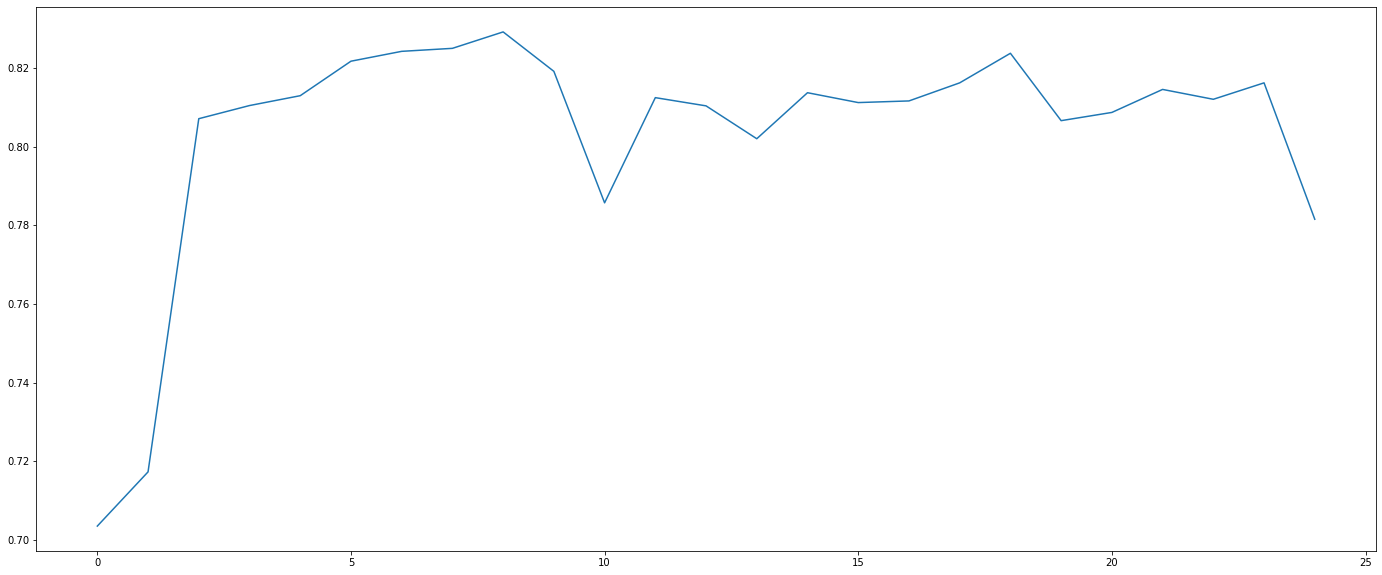

In [166]:
pd.Series(scores).plot(figsize=(24, 10));

In [167]:
purged_kfold = PurgedKFold(n_splits=folds, t1=cont["t1"], pctEmbargo=0.01)

In [168]:
y_pred, scores = cross_validate(X, y, cvGen=purged_kfold)

TRAIN: [ 2997  2998  2999 ... 59854 59855 59856] TEST: [   0    1    2 ... 2392 2393 2394]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56860, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 6.04538e-06
[2]	valid_0's focal_loss: 5.62263e-06
[3]	valid_0's focal_loss: 5.26018e-06
[4]	valid_0's focal_loss: 4.93016e-06
[5]	valid_0's focal_loss: 4.64492e-06
[6]	valid_0's focal_loss: 4.38953e-06
[7]	valid_0's focal_loss: 4.16889e-06
[8]	valid_0's focal_loss: 3.97759e-06
[9]	valid_0's focal_loss: 3.80821e-06
[10]	valid_0's focal_loss: 3.65776e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 2 ... 1 2 2]
FOLD's f1 score: 0.4096033402922756
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [2395 2396 2397 ... 4787 4788 4789]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56863, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.99274e-06
[2]	valid_0's focal_loss: 5.52082e-06
[3]	valid_0's focal_loss: 5.10472e-06
[4]	valid_0's focal_loss: 4.73626e-06
[5]	valid_0's focal_loss: 4.41092e-06
[6]	valid_0's focal_loss: 4.12066e-06
[7]	valid_0's focal_loss: 3.86511e-06
[8]	valid_0's focal_loss: 3.64018e-06
[9]	valid_0's focal_loss: 3.44306e-06
[10]	valid_0's focal_loss: 3.26816e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.5736951983298538
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [4790 4791 4792 ... 7182 7183 7184]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56862, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.98882e-06
[2]	valid_0's focal_loss: 5.5174e-06
[3]	valid_0's focal_loss: 5.09831e-06
[4]	valid_0's focal_loss: 4.72715e-06
[5]	valid_0's focal_loss: 4.39998e-06
[6]	valid_0's focal_loss: 4.10936e-06
[7]	valid_0's focal_loss: 3.85535e-06
[8]	valid_0's focal_loss: 3.63189e-06
[9]	valid_0's focal_loss: 3.43131e-06
[10]	valid_0's focal_loss: 3.2551e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [0 0 0 ... 2 1 1]
FOLD's f1 score: 0.6004175365344467
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [7185 7186 7187 ... 9577 9578 9579]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56861, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 6.05419e-06
[2]	valid_0's focal_loss: 5.63739e-06
[3]	valid_0's focal_loss: 5.27164e-06
[4]	valid_0's focal_loss: 4.95021e-06
[5]	valid_0's focal_loss: 4.66679e-06
[6]	valid_0's focal_loss: 4.41765e-06
[7]	valid_0's focal_loss: 4.19833e-06
[8]	valid_0's focal_loss: 4.00664e-06
[9]	valid_0's focal_loss: 3.8344e-06
[10]	valid_0's focal_loss: 3.68554e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [2 2 2 ... 1 1 1]
FOLD's f1 score: 0.2818371607515658
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [ 9580  9581  9582 ... 11972 11973 11974]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56865, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 6.04589e-06
[2]	valid_0's focal_loss: 5.62812e-06
[3]	valid_0's focal_loss: 5.25953e-06
[4]	valid_0's focal_loss: 4.93619e-06
[5]	valid_0's focal_loss: 4.65174e-06
[6]	valid_0's focal_loss: 4.40136e-06
[7]	valid_0's focal_loss: 4.18334e-06
[8]	valid_0's focal_loss: 3.99098e-06
[9]	valid_0's focal_loss: 3.82035e-06
[10]	valid_0's focal_loss: 3.67142e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [2 2 2 ... 0 0 0]
FOLD's f1 score: 0.3235908141962422
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [11975 11976 11977 ... 14367 14368 14369]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56863, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 6.01284e-06
[2]	valid_0's focal_loss: 5.56403e-06
[3]	valid_0's focal_loss: 5.16686e-06
[4]	valid_0's focal_loss: 4.81859e-06
[5]	valid_0's focal_loss: 4.50737e-06
[6]	valid_0's focal_loss: 4.23336e-06
[7]	valid_0's focal_loss: 3.99064e-06
[8]	valid_0's focal_loss: 3.7785e-06
[9]	valid_0's focal_loss: 3.59077e-06
[10]	valid_0's focal_loss: 3.42636e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [0 0 0 ... 2 2 1]
FOLD's f1 score: 0.4722338204592902
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [14370 14371 14372 ... 16762 16763 16764]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56862, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 6.04542e-06
[2]	valid_0's focal_loss: 5.62157e-06
[3]	valid_0's focal_loss: 5.25098e-06
[4]	valid_0's focal_loss: 4.92304e-06
[5]	valid_0's focal_loss: 4.63327e-06
[6]	valid_0's focal_loss: 4.37926e-06
[7]	valid_0's focal_loss: 4.15405e-06
[8]	valid_0's focal_loss: 3.95676e-06
[9]	valid_0's focal_loss: 3.78525e-06
[10]	valid_0's focal_loss: 3.62999e-06
preds.shape = (2395, 3), y_test.shape = (2395,)
After Softmax [1 1 1 ... 1 2 2]
FOLD's f1 score: 0.31440501043841335
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [16765 16766 16767 ... 19156 19157 19158]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56865, number of used features: 12
[LightGBM] [Warning] Using self-defined objective func

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.90429e-06
[2]	valid_0's focal_loss: 5.35088e-06
[3]	valid_0's focal_loss: 4.85518e-06
[4]	valid_0's focal_loss: 4.40996e-06
[5]	valid_0's focal_loss: 4.01309e-06
[6]	valid_0's focal_loss: 3.65705e-06
[7]	valid_0's focal_loss: 3.33841e-06
[8]	valid_0's focal_loss: 3.05315e-06
[9]	valid_0's focal_loss: 2.7978e-06
[10]	valid_0's focal_loss: 2.56978e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [2 1 0 ... 0 0 0]
FOLD's f1 score: 0.9030910609857978
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [19159 19160 19161 ... 21550 21551 21552]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.91718e-06
[2]	valid_0's focal_loss: 5.37792e-06
[3]	valid_0's focal_loss: 4.89347e-06
[4]	valid_0's focal_loss: 4.46181e-06
[5]	valid_0's focal_loss: 4.07583e-06
[6]	valid_0's focal_loss: 3.73222e-06
[7]	valid_0's focal_loss: 3.42242e-06
[8]	valid_0's focal_loss: 3.14603e-06
[9]	valid_0's focal_loss: 2.90072e-06
[10]	valid_0's focal_loss: 2.68045e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.8734335839598998
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [21553 21554 21555 ... 23944 23945 23946]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86676e-06
[2]	valid_0's focal_loss: 5.27751e-06
[3]	valid_0's focal_loss: 4.74791e-06
[4]	valid_0's focal_loss: 4.27182e-06
[5]	valid_0's focal_loss: 3.84389e-06
[6]	valid_0's focal_loss: 3.45932e-06
[7]	valid_0's focal_loss: 3.11321e-06
[8]	valid_0's focal_loss: 2.80186e-06
[9]	valid_0's focal_loss: 2.52188e-06
[10]	valid_0's focal_loss: 2.27014e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 1.0
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [23947 23948 23949 ... 26338 26339 26340]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.87724e-06
[2]	valid_0's focal_loss: 5.29762e-06
[3]	valid_0's focal_loss: 4.77727e-06
[4]	valid_0's focal_loss: 4.30963e-06
[5]	valid_0's focal_loss: 3.88937e-06
[6]	valid_0's focal_loss: 3.51188e-06
[7]	valid_0's focal_loss: 3.17326e-06
[8]	valid_0's focal_loss: 2.86823e-06
[9]	valid_0's focal_loss: 2.59347e-06
[10]	valid_0's focal_loss: 2.34724e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9774436090225563
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [26341 26342 26343 ... 28732 28733 28734]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.87045e-06
[2]	valid_0's focal_loss: 5.28479e-06
[3]	valid_0's focal_loss: 4.75866e-06
[4]	valid_0's focal_loss: 4.28567e-06
[5]	valid_0's focal_loss: 3.86101e-06
[6]	valid_0's focal_loss: 3.47918e-06
[7]	valid_0's focal_loss: 3.13575e-06
[8]	valid_0's focal_loss: 2.82735e-06
[9]	valid_0's focal_loss: 2.54998e-06
[10]	valid_0's focal_loss: 2.30098e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9933166248955723
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [28735 28736 28737 ... 31126 31127 31128]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.87505e-06
[2]	valid_0's focal_loss: 5.29497e-06
[3]	valid_0's focal_loss: 4.77299e-06
[4]	valid_0's focal_loss: 4.30369e-06
[5]	valid_0's focal_loss: 3.88198e-06
[6]	valid_0's focal_loss: 3.50299e-06
[7]	valid_0's focal_loss: 3.16236e-06
[8]	valid_0's focal_loss: 2.85656e-06
[9]	valid_0's focal_loss: 2.58165e-06
[10]	valid_0's focal_loss: 2.33449e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9711779448621554
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [31129 31130 31131 ... 33520 33521 33522]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.89426e-06
[2]	valid_0's focal_loss: 5.33134e-06
[3]	valid_0's focal_loss: 4.82543e-06
[4]	valid_0's focal_loss: 4.3713e-06
[5]	valid_0's focal_loss: 3.96262e-06
[6]	valid_0's focal_loss: 3.59872e-06
[7]	valid_0's focal_loss: 3.27334e-06
[8]	valid_0's focal_loss: 2.97968e-06
[9]	valid_0's focal_loss: 2.71632e-06
[10]	valid_0's focal_loss: 2.48017e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9302422723475355
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [33523 33524 33525 ... 35914 35915 35916]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.89073e-06
[2]	valid_0's focal_loss: 5.32354e-06
[3]	valid_0's focal_loss: 4.81563e-06
[4]	valid_0's focal_loss: 4.35872e-06
[5]	valid_0's focal_loss: 3.94907e-06
[6]	valid_0's focal_loss: 3.58165e-06
[7]	valid_0's focal_loss: 3.25362e-06
[8]	valid_0's focal_loss: 2.95753e-06
[9]	valid_0's focal_loss: 2.69386e-06
[10]	valid_0's focal_loss: 2.45713e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9461152882205514
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [35917 35918 35919 ... 38308 38309 38310]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.90588e-06
[2]	valid_0's focal_loss: 5.3546e-06
[3]	valid_0's focal_loss: 4.86046e-06
[4]	valid_0's focal_loss: 4.41828e-06
[5]	valid_0's focal_loss: 4.023e-06
[6]	valid_0's focal_loss: 3.66735e-06
[7]	valid_0's focal_loss: 3.35121e-06
[8]	valid_0's focal_loss: 3.06778e-06
[9]	valid_0's focal_loss: 2.81285e-06
[10]	valid_0's focal_loss: 2.58609e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9018379281537177
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [38311 38312 38313 ... 40702 40703 40704]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.92284e-06
[2]	valid_0's focal_loss: 5.3866e-06
[3]	valid_0's focal_loss: 4.90594e-06
[4]	valid_0's focal_loss: 4.47769e-06
[5]	valid_0's focal_loss: 4.09507e-06
[6]	valid_0's focal_loss: 3.7542e-06
[7]	valid_0's focal_loss: 3.44964e-06
[8]	valid_0's focal_loss: 3.17512e-06
[9]	valid_0's focal_loss: 2.93366e-06
[10]	valid_0's focal_loss: 2.71573e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.8441938178780284
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [40705 40706 40707 ... 43096 43097 43098]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functio

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86901e-06
[2]	valid_0's focal_loss: 5.28198e-06
[3]	valid_0's focal_loss: 4.75451e-06
[4]	valid_0's focal_loss: 4.28045e-06
[5]	valid_0's focal_loss: 3.85413e-06
[6]	valid_0's focal_loss: 3.47083e-06
[7]	valid_0's focal_loss: 3.12683e-06
[8]	valid_0's focal_loss: 2.81678e-06
[9]	valid_0's focal_loss: 2.53827e-06
[10]	valid_0's focal_loss: 2.28838e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9987468671679198
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [43099 43100 43101 ... 45490 45491 45492]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.89031e-06
[2]	valid_0's focal_loss: 5.32346e-06
[3]	valid_0's focal_loss: 4.81374e-06
[4]	valid_0's focal_loss: 4.35989e-06
[5]	valid_0's focal_loss: 3.94917e-06
[6]	valid_0's focal_loss: 3.58122e-06
[7]	valid_0's focal_loss: 3.24817e-06
[8]	valid_0's focal_loss: 2.94909e-06
[9]	valid_0's focal_loss: 2.68161e-06
[10]	valid_0's focal_loss: 2.44279e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.931077694235589
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [45493 45494 45495 ... 47884 47885 47886]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective functi

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86669e-06
[2]	valid_0's focal_loss: 5.27755e-06
[3]	valid_0's focal_loss: 4.74796e-06
[4]	valid_0's focal_loss: 4.27182e-06
[5]	valid_0's focal_loss: 3.84386e-06
[6]	valid_0's focal_loss: 3.45928e-06
[7]	valid_0's focal_loss: 3.11314e-06
[8]	valid_0's focal_loss: 2.80184e-06
[9]	valid_0's focal_loss: 2.52181e-06
[10]	valid_0's focal_loss: 2.27e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 1.0
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [47887 47888 47889 ... 50278 50279 50280]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.87374e-06
[2]	valid_0's focal_loss: 5.29052e-06
[3]	valid_0's focal_loss: 4.76648e-06
[4]	valid_0's focal_loss: 4.29644e-06
[5]	valid_0's focal_loss: 3.87396e-06
[6]	valid_0's focal_loss: 3.49421e-06
[7]	valid_0's focal_loss: 3.15271e-06
[8]	valid_0's focal_loss: 2.84644e-06
[9]	valid_0's focal_loss: 2.57062e-06
[10]	valid_0's focal_loss: 2.32266e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9807852965747702
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [50281 50282 50283 ... 52672 52673 52674]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective funct

/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86681e-06
[2]	valid_0's focal_loss: 5.27766e-06
[3]	valid_0's focal_loss: 4.74829e-06
[4]	valid_0's focal_loss: 4.27224e-06
[5]	valid_0's focal_loss: 3.84428e-06
[6]	valid_0's focal_loss: 3.45959e-06
[7]	valid_0's focal_loss: 3.11358e-06
[8]	valid_0's focal_loss: 2.80213e-06
[9]	valid_0's focal_loss: 2.52226e-06
[10]	valid_0's focal_loss: 2.2705e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 1.0
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [52675 52676 52677 ... 55066 55067 55068]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86677e-06
[2]	valid_0's focal_loss: 5.27785e-06
[3]	valid_0's focal_loss: 4.7483e-06
[4]	valid_0's focal_loss: 4.2722e-06
[5]	valid_0's focal_loss: 3.84424e-06
[6]	valid_0's focal_loss: 3.45952e-06
[7]	valid_0's focal_loss: 3.11341e-06
[8]	valid_0's focal_loss: 2.80199e-06
[9]	valid_0's focal_loss: 2.52187e-06
[10]	valid_0's focal_loss: 2.27009e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 1.0
TRAIN: [    0     1     2 ... 59854 59855 59856] TEST: [55069 55070 55071 ... 57460 57461 57462]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 56867, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86675e-06
[2]	valid_0's focal_loss: 5.27784e-06
[3]	valid_0's focal_loss: 4.74828e-06
[4]	valid_0's focal_loss: 4.27224e-06
[5]	valid_0's focal_loss: 3.84426e-06
[6]	valid_0's focal_loss: 3.45954e-06
[7]	valid_0's focal_loss: 3.11335e-06
[8]	valid_0's focal_loss: 2.80193e-06
[9]	valid_0's focal_loss: 2.52181e-06
[10]	valid_0's focal_loss: 2.27002e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 1.0
TRAIN: [    0     1     2 ... 57461 57462 57463] TEST: [57463 57464 57465 ... 59854 59855 59856]
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 57464, number of used features: 12
[LightGBM] [Warning] Using self-defined objective function


/Users/infatum/Development/LightGBM-with-Focal-Loss/venv/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's focal_loss: 5.86741e-06
[2]	valid_0's focal_loss: 5.2786e-06
[3]	valid_0's focal_loss: 4.74926e-06
[4]	valid_0's focal_loss: 4.2736e-06
[5]	valid_0's focal_loss: 3.84591e-06
[6]	valid_0's focal_loss: 3.46144e-06
[7]	valid_0's focal_loss: 3.11542e-06
[8]	valid_0's focal_loss: 2.80423e-06
[9]	valid_0's focal_loss: 2.52434e-06
[10]	valid_0's focal_loss: 2.27286e-06
preds.shape = (2394, 3), y_test.shape = (2394,)
After Softmax [0 0 0 ... 0 0 0]
FOLD's f1 score: 0.9995822890559732


In [169]:
np.mean(scores)

0.8064789217302127

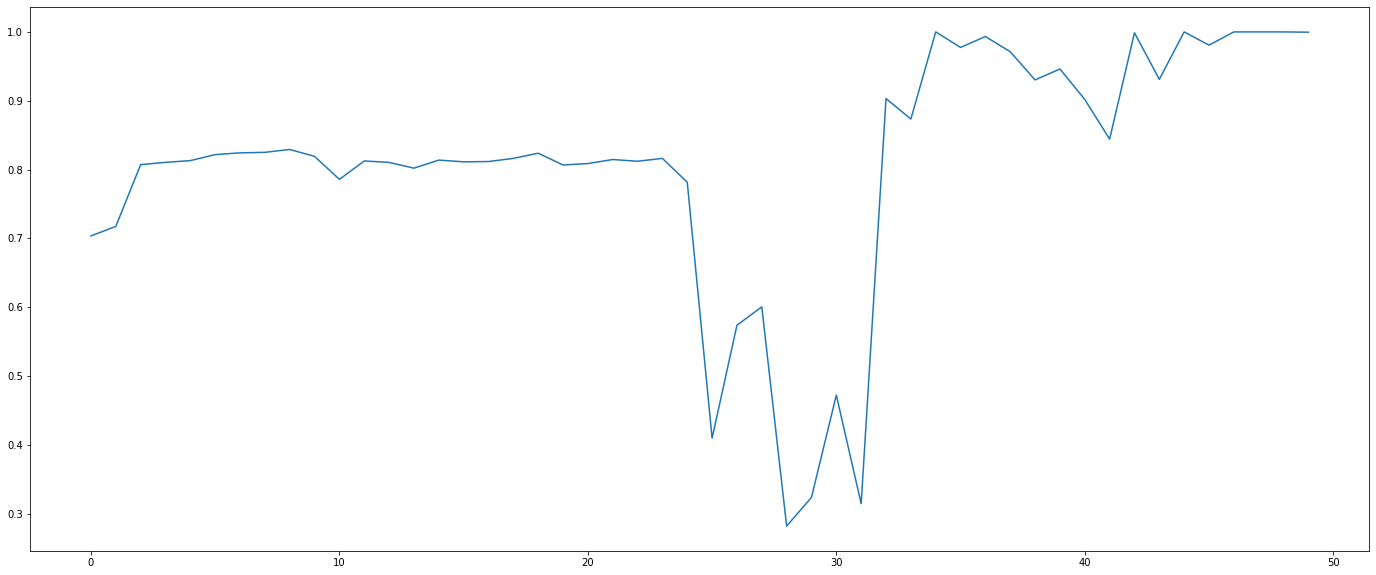

In [170]:
pd.Series(scores).plot(figsize=(24, 10));